In [24]:
INPUT_DIRECTORY = "../dataset"

# Importing Libraries

In [25]:
import os
import base64
import requests
import numpy as np
import pandas as pd
import itertools
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from scipy.interpolate import spline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
from keras import callbacks
from keras.callbacks import EarlyStopping, CSVLogger
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report

# Function Definition

In [107]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_



# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)




def load_data():
    filename = "all_attack_sampled_dataset.csv"
    file = os.path.join(INPUT_DIRECTORY,filename)
    df1 = pd.read_csv(file)
    return df1

def oversample(dfx):
    max_size = dfx ['SubLabel'].value_counts().max()
    lst = [dfx ]
    for class_index, group in dfx .groupby('SubLabel'):
        lst.append(group.sample(max_size-len(group), replace=True))
    dfx_new = pd.concat(lst)
    return dfx_new

def preprocess(df):
    print("Total number of features : ",len(df.columns))
    print("\n----Dropping features---")
    
    drop_columns = ['Timestamp','Src IP','Dst IP','Src Port','Flow ID']
    df.drop(drop_columns,inplace=True,axis=1)
    
    print("Number of features : ",len(df.columns))
    print("\n----Encoding categorical data---")
    
    df.loc[df['SubLabel']=='Normal', 'SubLabel'] = 0

    df.loc[df['SubLabel']=='ACK Scan', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='FIN Scan', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='TCP SYN Scan', 'SubLabel'] = 1
    df.loc[df['SubLabel']=='FTP Bounce Scan', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='Host Scan', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='Port Scan', 'SubLabel'] = 1
    df.loc[df['SubLabel']=='Xmas Scan', 'SubLabel'] = 5
    
    df.loc[df['SubLabel']=='DOS goldeneye', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='DOS Slowloris', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='ICMP Flood', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='Push ACK Flood', 'SubLabel'] =5 
    df.loc[df['SubLabel']=='SYN FIN Flood', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='UDP Flood', 'SubLabel'] = 5
    


    df.loc[df['SubLabel']=='SSH BruteForce', 'SubLabel'] = 2
    df.loc[df['SubLabel']=='FTP Bruteforce', 'SubLabel'] = 5
    df.loc[df['SubLabel']=='MySql BruteForce', 'SubLabel'] = 5
    
    df.loc[df['SubLabel']=='Malware Infiltration', 'SubLabel'] = 3
    
    df = df.drop(df[(df.SubLabel!= 0) & (df.SubLabel!= 1 )& (df.SubLabel!= 2)&(df.SubLabel!= 3)].index)

    
    
    # replacing normal by 0 and threat by 1 
    df.loc[df['Label']=='Normal', 'Label'] = 0
    df.loc[df['Label']=='Attack', 'Label'] = 1
   
     
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def evaluate_multiclass(y_pred, y_eval, history):
    #evaluation
    from sklearn import metrics
    print(metrics.classification_report(y_eval,y_pred, target_names=['Normal', 'Scan','Bruteforce','Malware']))
    print(f"Accuracy:{accuracy_score(y_eval,y_pred)*100}%")
    
    # Plot normalized confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    class_names = ['Normal', 'Scan','Bruteforce','Malware']
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm, classes=class_names, normalize=False,title='CONFUSION MATRIX \n\n Multiclass Classification \n')
    plt.show()

    #plot model loss
    plt.figure(figsize=(5,5))
    plt.plot(history.history['loss'], linewidth=2, label='Train',color = 'Green')
    plt.plot(history.history['val_loss'], linewidth=2, label='Valid',color ='Brown')
    plt.legend(loc='upper right')
    plt.title('MODEL LOSS CURVE')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    
def evaluate(y_pred, y_eval, history, Attack_name):
    #evaluation
    print(f"Accuracy:{accuracy_score(y_eval,y_pred)*100}%")
    print(f"Precison:{precision_score(y_eval,y_pred)*100}")
    print(f"Recall:{recall_score(y_eval,y_pred)*100}")
    print(f"F1-Score:{f1_score(y_eval, y_pred) *100}")
    

    # Plot normalized confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    class_names = ['Normal',Attack_name]
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cm, classes=class_names, normalize=False,title=f'CONFUSION MATRIX \n Normal vs {Attack_name} \n') 
    plt.show()

    # Print ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_eval, y_pred,pos_label=1)
    n = 20
    x_interp = np.linspace(0,0.1,n+1)
    y_interp = spline(fpr, tpr, x_interp, order=1)
    plt.figure(figsize=(5,5))
    plt.title(f'ROC CURVE \n {Attack_name} Classification \n')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(x_interp,y_interp)
    plt.show() 
#     print(x_interp, y_interp, thresholds)

    # Print AUC
    auc = np.trapz(tpr,fpr)
    print('AUC:', auc)
    
    

# Model definitions

In [108]:
# Dense Neural Network
#Dense Neural Network

def dnnmodel(x,y):
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Training and Testing the model ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
#     model.save("../models/modeldnnattack.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_test = np.argmax(y_test,axis=1)
    
    return y_pred ,  y_test, history

#Lstm NeuraL Network

def dnnmodel_multiclass():
    x = df1.iloc[:,0:78].values  
    y = df1.iloc[:,78:82].values
    
    #scale using minmaxscalar
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Dense Neural Network ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(x.shape[1], input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
    model.save("../models/modeldnnoversamplenew.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_eval = np.argmax(y_test,axis=1)
    
    #model summary
    print(model.summary())
    
    return y_pred ,  y_eval, history


def dnnmodel_multiclassf():
    x = df1.iloc[:,0:35].values  
    y = df1.iloc[:,35:41].values
    
    #scale using minmaxscalar
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Dense Neural Network ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(x.shape[1], input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
    model.save("../models/modeldnnoversample35.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_eval = np.argmax(y_test,axis=1)
    
    #model summary
    print(model.summary())
    
    return y_pred ,  y_eval, history



#Lstm NeuraL Network
def Lstm_model_multiclass():
    x = df1.iloc[:,0:78].values  
    y = df1.iloc[:,78:84].values
    
    # Feature Scaling
    sc = StandardScaler()  
    x = sc.fit_transform(x)  

     # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)
    
    
    # reshape input to be [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    batch_size = 64
    
    # 1. define the network
    model = Sequential()
    model.add(LSTM(64,input_dim=78, return_sequences=True))  
    model.add(LSTM(64, return_sequences=False)) 
    model.add(Dense(y.shape[1]))
    model.add(Activation('sigmoid'))
    
    #model summary
    print(model.summary())

    # try using different optimizers and different optimizer configs
    model.compile(loss='binary_crossentropy',optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
   
    #save model
    model.save("../models/modeltestLSTM.hdf5")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_test = np.argmax(y_test,axis=1)
    
     
    return y_pred ,  y_test, history


def dnnmodel_binary(df):
    
    x,y =  to_xy(df,'Label')
    
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


    print("#### Training and Testing the model ####")
    # Create neural net
    model = Sequential()
    model.add(Dense(54, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    #save model
    model.save("../models/modeltestdnnbinary.hdf5")
    print("Saved model to disk")
    
    #predict label
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis=1)
    y_test = np.argmax(y_test,axis=1)
    
    return y_pred ,  y_test, history



# Loading Data

In [109]:
df = load_data()

#Sample view of dataset
df.head()


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,192.168.10.9-110.44.113.201-59647-53-17,192.168.10.9,59647,110.44.113.201,53,17,26/07/2019 12:32:22 PM,63959,0,2,...,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Normal,Normal
1,192.168.10.100-8.8.8.8-54856-53-17,192.168.10.100,54856,8.8.8.8,53,17,22/07/2019 02:29:44 PM,103048,0,2,...,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Normal,Normal
2,192.168.10.2-192.168.10.6-80-27052-6,192.168.10.6,27052,192.168.10.2,80,6,26/07/2019 03:28:33 PM,34937948,1,1,...,0.0,0.0,0,0,0.000000e+00,0.000000e+00,0,0,Attack,SYN FIN Flood
3,185.82.212.199-192.168.10.9-80-32860-6,192.168.10.9,32860,185.82.212.199,80,6,26/07/2019 12:26:03 PM,64812032,6,1,...,7087197.0,0.0,7087197,7087197,1.924161e+07,1.289346e+07,33406563,8189633,Normal,Normal
4,192.168.10.7-239.255.255.250-0-0-0,192.168.10.7,0,239.255.255.250,0,0,22/07/2019 02:32:46 PM,119825401,6,1,...,0.0,0.0,0,0,2.380801e+07,1.594520e+07,48978764,7989707,Normal,Normal


# Statistical Summary

In [110]:
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,70456.000000,70456.000000,70456.000000,7.045600e+04,70456.000000,70456.000000,7.045600e+04,7.045600e+04,70456.000000,70456.000000,...,70456.000000,70456.0,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04,7.045600e+04
mean,42656.019445,13066.237978,8.899285,1.698287e+07,33.167523,34.191609,2.048875e+04,2.285805e+04,140.938600,7.777336,...,16.831384,0.0,5.205629e+05,1.116933e+05,6.421701e+05,4.409133e+05,6.342716e+06,9.650414e+05,7.228971e+06,5.572509e+06
std,19711.668361,20692.644673,4.909369,3.180906e+07,1080.697703,1047.846169,7.037731e+05,4.622271e+05,411.583824,42.708553,...,445.823474,0.0,2.497573e+06,8.709950e+05,2.887033e+06,2.370201e+06,1.364493e+07,5.194512e+06,1.583098e+07,1.281572e+07
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,37191.250000,68.000000,6.000000,3.469750e+03,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,51413.000000,443.000000,6.000000,4.362390e+05,1.000000,2.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,55885.000000,20031.000000,17.000000,1.132589e+07,3.000000,4.000000,9.600000e+01,1.870000e+02,54.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000496e+06,0.000000e+00,6.000520e+06,5.997663e+06
max,65535.000000,65530.000000,17.000000,1.200000e+08,172161.000000,171867.000000,4.468043e+07,4.455589e+07,20272.000000,1360.000000,...,30825.000000,0.0,1.099361e+08,5.162984e+07,1.099361e+08,1.099361e+08,1.199999e+08,7.402181e+07,1.199999e+08,1.199999e+08


# Label Distribution of Dataset

In [111]:
print('Label distribution of data set:')
print(df['SubLabel'].value_counts())
print()


Label distribution of data set:
Normal                  45048
DOS goldeneye            2860
FTP Bruteforce           2708
FTP Bounce Scan          2258
SYN FIN Flood            2156
Host Scan                2107
SSH BruteForce           1991
Port Scan                1966
ACK Scan                 1819
UDP Flood                1382
MySql BruteForce         1373
Push ACK Flood           1311
TCP SYN Scan             1000
Xmas Scan                 997
FIN Scan                  997
Malware Infiltration      449
DOS Slowloris              31
ICMP Flood                  3
Name: SubLabel, dtype: int64



# Step 1: Preprocessing and Encoding data

In [112]:
print("Shape of data:",df.shape)
preprocess(df)

#changing data type
df['Flow Byts/s'] = df['Flow Byts/s'].astype('float32')
df['Flow Pkts/s'] = df['Flow Pkts/s'].astype('float32')
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)

df.head()


Shape of data: (70456, 85)
Total number of features :  85

----Dropping features---
Number of features :  80

----Encoding categorical data---


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,50668,6,1,1,1,0,0,0,0,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,Normal,0
1,31889,17,9187228,2,1,40,20,20,20,20.000000,...,3120620.0,0.00000,3120620,3120620,6066608.0,0.000000,6066608,6066608,Normal,0
2,80,6,61028059,22,27,314,37014,314,0,14.272727,...,188177.0,264658.75449,375319,1035,30325841.0,471930.136832,30659546,29992136,Attack,5
3,55236,6,7067115,2,4,63,0,39,24,31.500000,...,327604.0,0.00000,327604,327604,6738517.0,0.000000,6738517,6738517,Normal,0
4,21,6,133,1,1,0,13,0,0,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,Attack,5


In [113]:
df.shape
print(df['SubLabel'].value_counts())

0    44769
5    20002
1     2966
2     1991
3      449
Name: SubLabel, dtype: int64


## Split Dataset into 5 datasets for every attack category

In [114]:
df_original = df.copy()
df = oversample(df)
df1=df.copy()
df= df.sample(frac=1).reset_index(drop=True) 
df1= df1.sample(frac=1).reset_index(drop=True)
df1.drop(['Label'], inplace = True , axis=1)
df.drop(['SubLabel'], inplace = True , axis=1)

In [115]:
#PortScan
df_PortScan = df1.drop(df1[(df1.SubLabel!= 1) & (df1.SubLabel!= 0)].index)
#DOS attack
# df_DOS = df1.drop(df1[(df1.SubLabel!= 2) & (df1.SubLabel!= 0) ].index)
#BruteForce
df_SSHBruteForce = df1.drop(df1[(df1.SubLabel!= 3) & (df1.SubLabel!= 0) ].index)
#Malware
df_Malware = df1.drop(df1[(df1.SubLabel!= 4) & (df1.SubLabel!= 0) ].index)


In [124]:
print(df1['SubLabel'].value_counts())

KeyError: 'SubLabel'

# Step 2: Feature Scaling:

In [125]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables

X_PortScan,Y_PortScan = to_xy(df_PortScan,'SubLabel')
Y_PortScanF = df_PortScan.SubLabel

X_SSHBruteForce,Y_SSHBruteForce = to_xy(df_SSHBruteForce,'SubLabel')
Y_SSHBruteForceF = df_SSHBruteForce.SubLabel

X_Malware,Y_Malware = to_xy(df_Malware,'SubLabel')
Y_MalwareF = df_Malware.SubLabel



## Use StandardScaler() to scale the dataframes

In [127]:
scaler1 = preprocessing.StandardScaler().fit(X_PortScan)
X_PortScan = scaler1.transform(X_PortScan) 

scaler3 = preprocessing.StandardScaler().fit(X_SSHBruteForce)
X_SSHBruteForce = scaler3.transform(X_SSHBruteForce) 

scaler4 = preprocessing.StandardScaler().fit(X_Malware)
X_Malware = scaler4.transform(X_Malware) 



# Step 3: Feature Selection:


## 1. Univariate Feature Selection using ANOVA F-test

In [128]:
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
colNames=list(df1)

selector=SelectPercentile(f_classif, percentile=50)
X_newPortScan = selector.fit_transform(X_PortScan,Y_PortScanF)
X_newPortScan.shape


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [31 33 34 49 50 51 56 57 58 59 60 61 66 69] are constant.
  UserWarning)


(89538, 39)

## Get the features that were selected: Port Scan

In [129]:
true=selector.get_support()
newcolindex_PortScan=[i for i, x in enumerate(true) if x]
newcolname_PortScan=list( colNames[i] for i in newcolindex_PortScan )
newcolname_PortScan

['Protocol',
 'Flow Duration',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'SYN Flag Cnt',
 'ACK Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Init Bwd Win Byts',
 'Active Mean',
 'Active Max',
 'Active Min',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

In [130]:
X_newSSHBruteForce = selector.fit_transform(X_SSHBruteForce ,Y_SSHBruteForceF)
X_newSSHBruteForce .shape

/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [31 33 34 49 50 51 56 57 58 59 60 61 66 69] are constant.
  UserWarning)


(89538, 39)

## Get the features that were selected: SSHBruteForce 

In [131]:
true=selector.get_support()
newcolindex_SSHBruteForce =[i for i, x in enumerate(true) if x]
newcolname_SSHBruteForce =list( colNames[i] for i in newcolindex_SSHBruteForce  )
newcolname_SSHBruteForce 

['Dst Port',
 'Protocol',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Min',
 'Fwd IAT Std',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd PSH Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'Down/Up Ratio',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Subflow Fwd Pkts',
 'Subflow Fwd Byts',
 'Subflow Bwd Pkts',
 'Init Bwd Win Byts',
 'Fwd Act Data Pkts',
 'Active Mean',
 'Active Min']

In [132]:
X_newMalware = selector.fit_transform(X_Malware ,Y_MalwareF)
X_newMalware.shape

(44769, 39)

## Get the features that were selected: Malware

In [133]:
true=selector.get_support()
newcolindex_Malware =[i for i, x in enumerate(true) if x]
newcolname_Malware =list( colNames[i] for i in newcolindex_Malware)
newcolname_Malware

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s']

# 2. Recursive Feature Elimination

In [134]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
clf = DecisionTreeClassifier(random_state=0)

rfe = RFE(estimator=clf, n_features_to_select=39, step=1)
rfe.fit(X_PortScan, Y_PortScanF)
X_rfePortScan=rfe.transform(X_PortScan)

## Get the features that were selected: Port Scan

In [135]:
true=rfe.support_
rfecolindex_PortScan=[i for i, x in enumerate(true) if x]
rfecolname_PortScan=list(colNames[i] for i in rfecolindex_PortScan)
rfecolname_PortScan

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg']

In [137]:
rfe.fit(X_SSHBruteForce, Y_SSHBruteForceF)
X_rfeSSHBruteForce=rfe.transform(X_SSHBruteForce)


## Get the features that were selected: SSH BruteForce

In [138]:
## Get the features that were selected: SSH BruteForcetrue
rfe.support_
rfecolindex_SSHBruteForce=[i for i, x in enumerate(true) if x]
rfecolname_SSHBruteForce=list(colNames[i] for i in rfecolindex_SSHBruteForce)
rfecolname_SSHBruteForce

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg']

In [139]:
rfe.fit(X_Malware,Y_MalwareF)
X_rfeMalware=rfe.transform(X_Malware)

## Get the features that were selected: Malware

In [140]:
## Get the features that were selected: Malwaretrue
rfe.support_
rfecolindex_Malware=[i for i, x in enumerate(true) if x]
rfecolname_Malware=list(colNames[i] for i in rfecolindex_Malware)
rfecolname_Malware

['Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg']

# 3. Feature Selection

In [141]:
dff = df1.copy()
dff.drop(dff.columns.difference(['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean',
       'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
       'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std',
       'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min',
       'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Pkt Len Min', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
       'ACK Flag Cnt', 'Down/Up Ratio', 'Init Bwd Win Byts', 'Idle Mean',
       'Idle Std','SubLabel']), 1, inplace=True)
dff.head()

,Dst Port,Flow Duration,Tot Fwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,...,Fwd Pkts/s,Pkt Len Min,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,ACK Flag Cnt,Down/Up Ratio,Init Bwd Win Byts,Idle Mean,Idle Std
0,34318,1120,0,0,0,0,0.0,0.0,0,0,...,0.000000,0,0,1,0,0,0,0,0.0,0.0
1,22,2610,0,0,0,0,0.0,0.0,0,0,...,0.000000,0,1,0,0,1,0,237,0.0,0.0
2,61359,1137,0,0,0,0,0.0,0.0,0,0,...,0.000000,0,0,1,0,0,0,0,0.0,0.0
3,54775,324465,1,0,0,0,0.0,0.0,0,0,...,3.081997,0,0,0,0,1,1,123,0.0,0.0
4,26524,947,0,0,0,0,0.0,0.0,0,0,...,0.000000,0,0,1,0,0,0,0,0.0,0.0


# Step 4: Build The Model

## 1. Model is trained for all features 


In [142]:
#Fit Dense Neural Network
y_pred_PortScan,y_eval_PortScan,h_PortScan = dnnmodel(X_PortScan,Y_PortScan)

y_pred_SSHBruteForce,y_eval_SSHBruteForce,h_SSHBruteForce = dnnmodel(X_SSHBruteForce ,Y_SSHBruteForce )

y_pred_Malware,y_eval_Malware,h_Malware = dnnmodel(X_Malware,Y_Malware)


#### Training and Testing the model ####
Train on 62676 samples, validate on 26862 samples
Epoch 1/1000
 - 10s - loss: 0.1189 - val_loss: 0.0959
Epoch 2/1000
 - 7s - loss: 0.0801 - val_loss: 0.0711
Epoch 3/1000
 - 6s - loss: 0.0664 - val_loss: 0.0682
Epoch 4/1000
 - 8s - loss: 0.0572 - val_loss: 0.0551
Epoch 5/1000
 - 8s - loss: 0.0496 - val_loss: 0.0531
Epoch 6/1000
 - 7s - loss: 0.0434 - val_loss: 0.0462
Epoch 7/1000
 - 5s - loss: 0.0394 - val_loss: 0.0379
Epoch 8/1000
 - 6s - loss: 0.0369 - val_loss: 0.0298
Epoch 9/1000
 - 4s - loss: 0.0356 - val_loss: 0.0301
Epoch 10/1000
 - 5s - loss: 0.0344 - val_loss: 0.0364
Epoch 11/1000
 - 4s - loss: 0.0309 - val_loss: 0.0260
Epoch 12/1000
 - 4s - loss: 0.0282 - val_loss: 0.0855
Epoch 13/1000
 - 4s - loss: 0.0299 - val_loss: 0.0258
Epoch 14/1000
 - 4s - loss: 0.0284 - val_loss: 0.0218
Epoch 15/1000
 - 4s - loss: 0.0283 - val_loss: 0.0209
Epoch 16/1000
 - 4s - loss: 0.0262 - val_loss: 0.0203
Epoch 17/1000
 - 4s - loss: 0.0262 - val_loss: 0.0244

ValueError: You are passing a target array of shape (31338, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

## 2. Model is trained for selected features

### ANOVA Univariate Feature Selection

In [ ]:
#Fit Dense Neural Network

y_pred_newPortScan,y_eval_newPortScan,h_newPortScan = dnnmodel(X_newPortScan,Y_PortScan)

y_pred_newSSHBruteForce,y_eval_newSSHBruteForce,h_newSSHBruteForce = dnnmodel(X_newSSHBruteForce ,Y_SSHBruteForce )

y_pred_newMalware,y_eval_newMalware,h_newMalware = dnnmodel(X_newMalware,Y_Malware)


### Recursive Feature Elimination

In [ ]:
#Fit Dense Neural Network

y_pred_rfePortScan,y_eval_rfePortScan,h_rfePortScan = dnnmodel(X_rfePortScan,Y_PortScan)

y_pred_rfeSSHBruteForce,y_eval_rfeSSHBruteForce,h_rfeSSHBruteForce = dnnmodel(X_rfeSSHBruteForce ,Y_SSHBruteForce )

y_pred_rfeMalware,y_eval_rfeMalware,h_rfeMalware = dnnmodel(X_rfeMalware,Y_Malware)


## 3. Multiclass Classification

### Dense Neural Network

In [ ]:
encode_text_dummy(df1,'SubLabel')
# encode_text_dummy(dff,'SubLabel')

In [117]:
print("With all Features")
y_pred_dnn, y_eval_dnn, h_dnn  = dnnmodel_multiclass()
# print("With selected 35 Features")
# y_pred_dnns, y_eval_dnns, h_dnns  = dnnmodel_multiclassf()


With all Features
#### Dense Neural Network ####
Train on 156691 samples, validate on 67154 samples
Epoch 1/1000
 - 20s - loss: 0.1256 - val_loss: 0.0801
Epoch 2/1000
 - 20s - loss: 0.0646 - val_loss: 0.0580
Epoch 3/1000
 - 21s - loss: 0.0525 - val_loss: 0.0476
Epoch 4/1000
 - 22s - loss: 0.0456 - val_loss: 0.0464
Epoch 5/1000
 - 21s - loss: 0.0407 - val_loss: 0.0416
Epoch 6/1000
 - 17s - loss: 0.0369 - val_loss: 0.0359
Epoch 7/1000
 - 21s - loss: 0.0350 - val_loss: 0.0382
Epoch 8/1000
 - 17s - loss: 0.0337 - val_loss: 0.0393
Epoch 9/1000
 - 33s - loss: 0.0387 - val_loss: 0.0409
Epoch 10/1000
 - 26s - loss: 0.0384 - val_loss: 0.0364
Epoch 11/1000
 - 22s - loss: 0.0363 - val_loss: 0.0360
Epoch 00011: early stopping
Saved model to disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 78)                6162      
__________________________________________________________

# Step 4: Evaluate the model 

In [ ]:
df.loc[df['Label']=='Normal', 'Label'] = 0
df.loc[df['Label']=='Attack', 'Label'] = 1
   
print(df['Label'].value_counts())


In [ ]:
y_pred_dnnb, y_eval_dnnb, h_dnnb  = dnnmodel_binary(df)

# Accuracy, Precision, Recall, F1score

## Port Scan

In [ ]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_PortScan, y_eval_PortScan, h_PortScan,'Port Scan' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newPortScan,y_eval_newPortScan,h_newPortScan, 'Port Scan')
#evaluate with selected features
print("Evaluation with selected features using RFE")
evaluate(y_pred_rfePortScan,y_eval_rfePortScan,h_rfePortScan, 'Port Scan')

## DOS

In [ ]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_DOS, y_eval_DOS, h_DOS, 'DOS Attack' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newDOS,  y_eval_newDOS,h_newDOS, 'DOS Attack')
print("Evaluation with selected features using RFE")
evaluate(y_pred_rfeDOS,  y_eval_rfeDOS,h_rfeDOS, 'DOS Attack')

## SSHBruteForce

In [ ]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_SSHBruteForce , y_eval_SSHBruteForce , h_SSHBruteForce, 'Brute Force' )
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newSSHBruteForce,y_eval_newSSHBruteForce,h_newSSHBruteForce , 'Brute Force')
#evaluate with selected features
print("Evaluation with selected features using RFE")
evaluate(y_pred_rfeSSHBruteForce,y_eval_rfeSSHBruteForce,h_rfeSSHBruteForce, 'Brute Force')

## Malware

In [ ]:
#evaluate with all features
print("Evaluation with all features")
evaluate(y_pred_DOS, y_eval_DOS, h_DOS , 'Malware')
#evaluate with selected features
print("Evaluation with selected features using ANOVA")
evaluate(y_pred_newDOS,  y_eval_newDOS,h_newDOS, 'Malware')
#evaluate with selected features
print("Evaluation with selected features using RFE")
evaluate(y_pred_rfeDOS,  y_eval_rfeDOS,h_rfeDOS , 'Malware')


# Multiclass Classification

###   Dense Neural Network

With all the features
              precision    recall  f1-score   support

      Normal       0.99      0.82      0.90     27039
        Scan       0.85      0.99      0.92     13374
  Bruteforce       0.85      0.99      0.91     13383
     Malware       0.99      1.00      0.99     13358

    accuracy                           0.92     67154
   macro avg       0.92      0.95      0.93     67154
weighted avg       0.93      0.92      0.92     67154

Accuracy:92.32659260803527%
Confusion matrix, without normalization


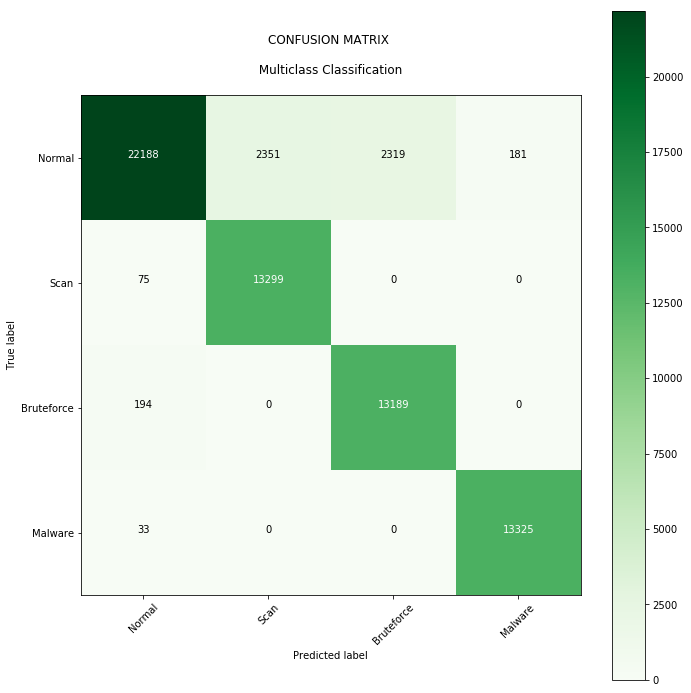

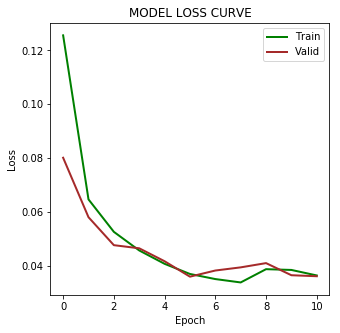

In [123]:
print("With all the features")
evaluate_multiclass(y_pred_dnn, y_eval_dnn, h_dnn )
# print("With selected 35 features")
# evaluate_multiclass(y_pred_dnn, y_eval_dnn, h_dnn )